In [211]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom
from skimage.restoration import denoise_tv_chambolle

#MNIST dataset
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN, DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP, RED
from deepinv.utils.parameters import get_GSPnP_params
from deepinv.optim.optimizers import optim_builder


torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([transforms.ToTensor()])


def PSNR(original, img):
    max_value =  1
    mse = F.mse_loss(original.flatten(), img.flatten())
    if mse == 0:
        return 100
    psnr = 20 * torch.log10(max_value / (torch.sqrt(mse)))
    return psnr



In [3]:
#Radon transform

def forward_operator_radon(n, angles):
    """
    Forward operator - Radon transform discretised version with matrix A^(n^2 x m)
    n - number of pixels of input image
    m - number of angles for the Radon transform to be performed
    """
    circle = False
    theta = np.linspace(0., 180., angles, endpoint=False)
    size = radon(np.zeros((n, n)), theta=theta, circle=circle).shape
    M = size[0] * size[1]
    A = torch.zeros((M, n**2), dtype=torch.float32)
    
    for i in range(n**2):
        e = torch.zeros((n**2,), dtype=torch.float32)
        e[i] = 1
        e = e.view(n, n)
        
        # Convert e to numpy for radon
        sinogram = radon(e.numpy(), theta=theta, circle=circle)
        
        # Convert sinogram back to torch and assign to A
        A[:, i] = torch.from_numpy(sinogram.flatten())
    
    return A


n = 84
n_angles = 60
phantom = resize(shepp_logan_phantom(), (n,n))




A = forward_operator_radon(n, n_angles)


In [107]:
torch.norm(A)

tensor(538.7946)

In [118]:
#RGB Radon transform
A_red = A
A_green = A
A_blue = A
phantom_rgb = np.stack([phantom]*3, axis=1)
phantom_rgb_tensor = torch.from_numpy(phantom_rgb).permute(2, 0, 1).float()
phantom_rgb_tensor.shape

torch.Size([84, 84, 3])

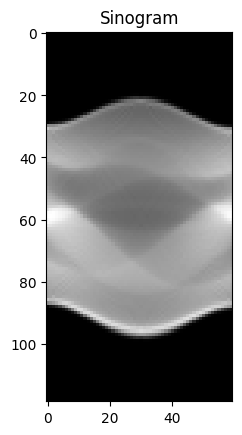

In [35]:
imsize = (n, n)
phantom = resize(shepp_logan_phantom(), (n,n))
y = np.reshape(A@phantom.flatten(), (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')
#ground truth
x = torch.from_numpy(phantom).flatten().float()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 59.5, 118.5, -0.5)

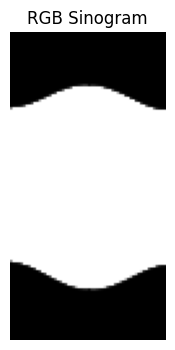

In [149]:
rgb_sinogram = torch.stack([y]*3, axis=-1)
plt.figure(figsize=(10, 4))
plt.imshow(rgb_sinogram)
plt.title("RGB Sinogram")
plt.axis('off')


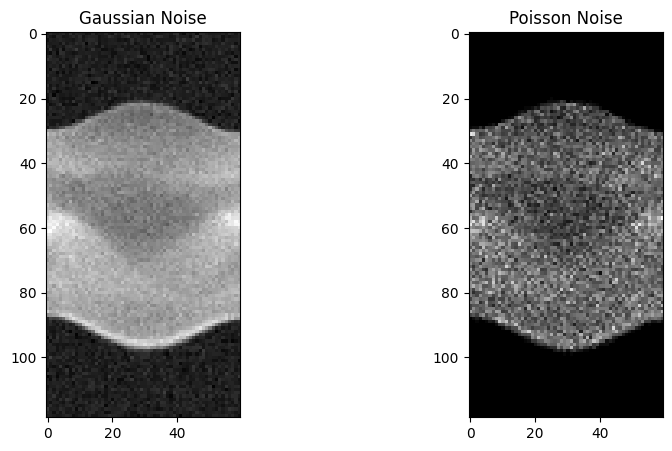

In [41]:
# Add noise to the sinogram (Gaussian and Poisson)
def add_noise(sinogram, noise_type='gaussian', sigma=0.01):
    """
    Add different types of noise to a sinogram
    sinogram - original sinogram input
    noise_type - the type of noise to add ['gaussian', 'poisson']
    sigma - standard deviation for Gaussian noise input
    """

    if noise_type == 'gaussian':
        noise = torch.randn_like(sinogram) * sigma
        noisy_sinogram = sinogram + noise
    
    elif noise_type == 'poisson':
        noisy_sinogram = torch.poisson(sinogram)


    return noisy_sinogram


# FBP reconstruction in torch
def fbp(sinogram, angles):
    sinogram_np = sinogram.numpy()
    theta = np.linspace(0., 180., angles, endpoint=False)
    reconstructed_image = iradon(sinogram_np, theta=theta, circle=False)
    return torch.from_numpy(reconstructed_image)



# Add Gaussian and Poisson noise to the sinogram
sigma = 1
gauss_y = add_noise(y, noise_type='gaussian', sigma = sigma).float()
poisson_y = add_noise(y, noise_type='poisson').float()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Gaussian Noise")
plt.imshow(gauss_y.numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Poisson Noise")
plt.imshow(poisson_y.numpy(), cmap='gray')

Text(0.5, 1.0, 'Noise-free FBP reconstruction')

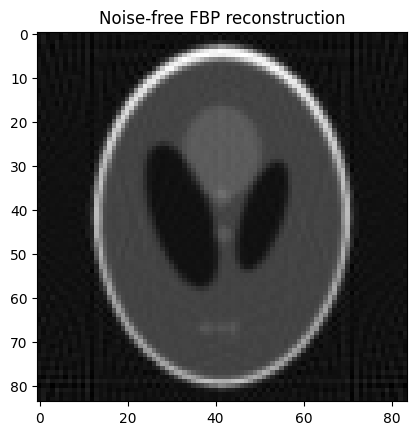

In [163]:
#Noise free FBP

reconstruction_fbp = fbp(y, n_angles)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Noise-free FBP reconstruction')


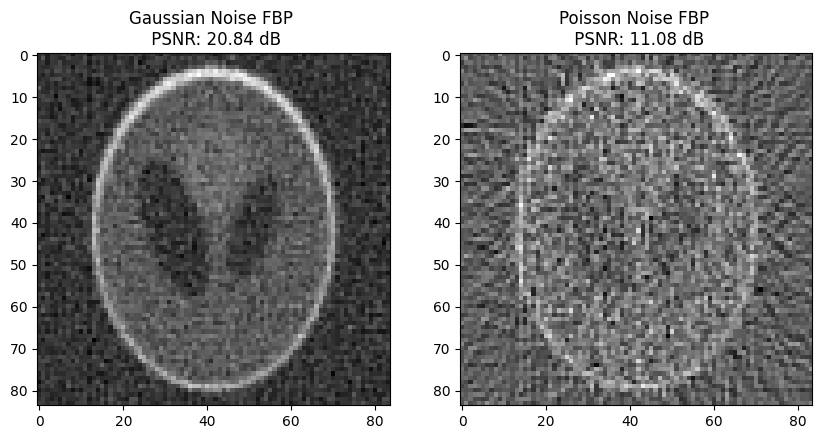

In [42]:
#Noisy reconstruction
gfbp = fbp(gauss_y, n_angles)
pfbp = fbp(poisson_y, n_angles)

g_psnr = PSNR(x, gfbp)
p_psnr = PSNR(x, pfbp)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Gaussian Noise FBP \n PSNR: {g_psnr:.2f} dB")
plt.imshow(gfbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Poisson Noise FBP \n PSNR: {p_psnr:.2f} dB")
plt.imshow(pfbp, cmap='gray')

In [21]:
# plotting functions

def comparison_plot(norm_res, method, ytitle='PSNR', color='k', title = 'PSNR'):
    K = len(norm_res)

    plt.plot(range(1, len(norm_res) + 1),norm_res, color=color, label=method)
    k = np.arange(K)
    plt.title(title)
    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid(True)

def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        
        #cur_min = np.round(np.amin(img), 1)
        #cur_max = np.round(np.amax(img), 1)
        #bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        psnr = PSNR(ground_truth, img)
        titles.append(title + f' PSNR: {psnr:.2f} dB \n')
        

        #nrmse = pnpm.nrmse(img, ground_truth)
        #titles.append(title + ' [NRMSE: ' + str(nrmse) + ']')

    for img, title in zip(image_list, titles):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 5))
        

        ax.imshow(img, cmap='gray')
        #pnpm.display_image(img, fig=fig, ax=ax, cmap='gray')

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()

# Optimisation algorithms (PGD and ADMM) for reconstruction (priors)

In [12]:
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

In [189]:
#GS-DRUNet class with GSPnP and the GS-DRUNet function
import torch
import torch.nn as nn
from deepinv.models.utils import get_weights_url



class StudentGrad(nn.Module):
    def __init__(self, denoiser):
        super().__init__()
        self.model = denoiser

    def forward(self, x, sigma):
        return self.model(x, sigma)


class GSPnP(nn.Module):
    r"""
    Gradient Step module to use a denoiser architecture as a Gradient Step Denoiser.
    See https://arxiv.org/pdf/2110.03220.pdf.
    Code from https://github.com/samuro95/GSPnP.

    :param nn.Module denoiser: Denoiser model.
    :param float alpha: Relaxation parameter
    """

    def __init__(self, denoiser, alpha=1.0, train=False):
        super().__init__()
        self.student_grad = StudentGrad(denoiser)
        self.alpha = alpha
        self.train = train

    def potential(self, x, sigma, *args, **kwargs):
        N = self.student_grad(x, sigma)
        return (
            0.5
            * self.alpha
            * torch.norm((x - N).view(x.shape[0], -1), p=2, dim=-1) ** 2
        )

    def potential_grad(self, x, sigma, *args, **kwargs):
        r"""
        Calculate :math:`\nabla g` the gradient of the regularizer :math:`g` at input :math:`x`.

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level :math:`\sigma` (std)
        """
        with torch.enable_grad():
            x = x.float()
            x = x.requires_grad_()
            N = self.student_grad(x, sigma)
            JN = torch.autograd.grad(
                N, x, grad_outputs=x - N, create_graph=True, only_inputs=True
            )[0]
        Dg = x - N - JN
        return self.alpha * Dg

    def forward(self, x, sigma):
        r"""
        Denoising with Gradient Step Denoiser

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level (std)
        """
        Dg = self.potential_grad(x, sigma)
        x_hat = x - Dg
        return x_hat


def GSDRUNet(
    alpha=1.0,
    in_channels=3,
    out_channels=3,
    nb=2,
    nc=[64, 128, 256, 512],
    act_mode="E",
    pretrained=None,
    train=False,
    device=torch.device("cpu"),
):
    """
    Gradient Step Denoiser with DRUNet architecture

    :param float alpha: Relaxation parameter
    :param int in_channels: Number of input channels
    :param int out_channels: Number of output channels
    :param int nb: Number of blocks in the DRUNet
    :param list nc: Number of channels in the DRUNet
    :param str act_mode: activation mode, "R" for ReLU, "L" for LeakyReLU "E" for ELU and "S" for Softplus.
    :param str downsample_mode: Downsampling mode, "avgpool" for average pooling, "maxpool" for max pooling, and
        "strideconv" for convolution with stride 2.
    :param str upsample_mode: Upsampling mode, "convtranspose" for convolution transpose, "pixelsuffle" for pixel
        shuffling, and "upconv" for nearest neighbour upsampling with additional convolution.
    :param bool download: use a pretrained network. If ``pretrained=None``, the weights will be initialized at random
        using Pytorch's default initialization. If ``pretrained='download'``, the weights will be downloaded from an
        online repository (only available for the default architecture).
        Finally, ``pretrained`` can also be set as a path to the user's own pretrained weights.
        See :ref:`pretrained-weights <pretrained-weights>` for more details.
    :param bool train: training or testing mode.
    :param str device: gpu or cpu.

    """
    from deepinv.models.drunet import DRUNet

    denoiser = DRUNet(
        in_channels=in_channels,
        out_channels=out_channels,
        nb=nb,
        nc=nc,
        act_mode=act_mode,
        pretrained=None,
        train=train,
        device=device,
    )
    GSmodel = GSPnP(denoiser, alpha=alpha, train=train)
    if pretrained:
        if pretrained == "download":
            if in_channels == 3 and out_channels == 3:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_torch.ckpt",
                )
            elif in_channels == 1 and out_channels == 1:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_grayscale_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_grayscale_torch.ckpt",
                )
        else:
            ckpt = torch.load(pretrained, map_location=lambda storage, loc: storage)

        if "state_dict" in ckpt:
            ckpt = ckpt["state_dict"]

        GSmodel.load_state_dict(ckpt, strict=False)
    return GSmodel




In [190]:
#Deep denoisers
channels = 1
# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior()
bm3dprior = dinv.models.BM3D()

priorbm3d = PnP(denoiser = bm3dprior)
prior1 = PnP(denoiser = dncnn)
prior2 = PnP(denoiser = drunet)


In [206]:
gsdrunet = GSDRUNet(
    in_channels= 1,
    out_channels= 1,
    pretrained="download",
    device="cpu",
)

test = gfbp.unsqueeze(0).unsqueeze(0)
print(test.shape)
#drunet(test, sigma = sigma)
dncnn(test, sigma = sigma)

torch.Size([1, 1, 84, 84])


tensor([[[[-0.0552,  0.0348, -0.1219,  ..., -0.0618, -0.1067, -0.1033],
          [-0.0621,  0.1835, -0.0869,  ...,  0.1086,  0.0569, -0.0484],
          [-0.0161,  0.0318, -0.0969,  ...,  0.0030,  0.0788, -0.0446],
          ...,
          [-0.0758,  0.0259,  0.0090,  ..., -0.0935, -0.1040,  0.0127],
          [-0.0364,  0.0577, -0.0398,  ..., -0.0967,  0.1278,  0.1141],
          [ 0.0531,  0.0535, -0.0375,  ..., -0.0456,  0.0745,  0.0076]]]])

In [214]:
#PnP-PGD
#ISTA
def soft_thresh(x, l):
    return torch.sign(x) * F.relu(torch.abs(x) - l)


def denoiser(x, l, method = 'tv', sigma = sigma):
        """
        Denoiser options to replace the proximal step
        """
        L = torch.norm(A) ** 2  # Lipschitz constant
        if method == 'tv':
            return denoise_tv_chambolle_torch(x, weight = l)
        elif method == 'bm3d':
            x = bm3d(x.reshape(imsize), sigma_psd = sigma).flatten()
            return torch.from_numpy(x).float()
        elif method == 'proximal':
            return soft_thresh(x, l)
        elif method == 'DnCNN':
            x = x.reshape(imsize)
            #print("x shape before:", x.shape)
            x = x.unsqueeze(0).unsqueeze(0)
            #print("x shape after:", x.shape)
            x = dncnn(x, sigma = sigma)
            return x.squeeze(0).squeeze(0).flatten()
        elif method == 'DRUNet':
            x = x.reshape(imsize)
            x = x.unsqueeze(0).unsqueeze(0)
            #print("x shape before:", x.shape)
            x = dncnn(x, sigma = sigma)
            return x.squeeze(0).squeeze(0).flatten()
        elif method == "GS-DRUNet":
            x = x.reshape(imsize)
            #print("x shape before:", x.shape)
            x = x.unsqueeze(0).unsqueeze(0)
            #print("x shape after:", x.shape)
            x = gsdrunet(x, sigma = sigma)
            x =  x.squeeze(0).squeeze(0)
            return x.flatten()


def pnp_pgd(A, b, x_truth, method = None, reg_l = 1e-5, iters = 50, tol = 1e-3, sigma = sigma):
    """
    PnP iterative shrinkage thrseholding algorithm (PnP-ISTA)
    """

    x = torch.zeros_like(x_truth, requires_grad=False)
    #x = fbp(b, n_angles).flatten()
    psnrs = []
    iterates_pairs = []
    differences = []
    L = torch.norm(A) ** 2  # Lipschitz constant
    t = 1 / L # Initial stepsize
    b = b.flatten()

    #f = lambda x: 0.5 * torch.norm(A @ x - b) ** 2
    #grad_f =lambda x: A.T @ (A @ x - b)

    for i in tqdm(range(iters), desc = str(method) + '-PnP PGD iterations'):
        #gradient descent step
        current_grad = A.T @ (A @ x - b)
        #print("current gradient:", current_grad)
        x_new = x - (t * current_grad)
           
        """
        #backtracking line search (Armijo condition)
        while True:
            x_new = x - (t * current_grad)
            if (torch.norm(A @ (x_new - x)) ** 2) <=  t*(current_grad.T @ current_grad):
                break
            t *= 0.5
        """

        #denoising step (proximal step)
        denoised_x = denoiser(x_new, reg_l, method = method, sigma = sigma)
        #x = soft_thresh(x_descent, l / L)

        #inverted and denoised iterates stored
        iterates_pairs.append((x_new, denoised_x))
        #difference between "noisy and denoised iterates"
        diff = x_new - denoised_x
        differences.append(diff)
        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)

        #new estimate
        x = denoised_x
        psnr = PSNR(x_truth, x)
        psnrs.append(psnr)
        if torch.norm(current_grad) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, torch.norm(current_grad), tol))
            break

    print(f"PnP-{method} Final PSNR: {psnr:.2f} dB")

    return x, psnrs, differences, iterates_pairs



def pnp_fista(A, b, x_truth, method = None, reg_l = 1e-5, iters = 50, tol = 1e-3, sigma = sigma):
    """
    PnP FISTA (accelerated PGD)
    """
    #ground = 0.5 * np.linalg.norm(A.dot(x_g) - b) ** 2 + l * np.linalg.norm(x_g, 1)
    x = torch.zeros_like(x_truth, requires_grad=False)
    #x = fbp(b, n_angles).flatten()
    psnrs = []
    iterates_pairs = []
    differences = []
    relative = []
    L = torch.norm(A) ** 2  # Lipschitz constant
    #t = 1 / L # Initial stepsize
    b = b.flatten()
    

    #Initialisation of parameters (step size and initial guesses)
    t = 1
    z = x.clone()
    
    for i in tqdm(range(iters), desc = 'PnP FISTA iterations'):
        grad_g = A.T @ (A @ x - b)
        xold = x.clone()
        z = z + A.T @(b - A @ z) / L
        x = denoiser(z, reg_l, method)
        t0 = t
        t = (1 + torch.sqrt(torch.tensor(1 + 4 * t ** 2))) / 2.
        z = x + ((t0 - 1) / t) * (x - xold)
        
        rel = torch.norm(x - x_truth)/torch.norm(x_truth)
        relative.append(rel)

        #inverted and denoised iterates stored
        iterates_pairs.append((z, x))
        #difference between "noisy and denoised iterates"
        diff = z - x 
        differences.append(diff)

        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)

        psnr = PSNR(x_truth, x)
        psnrs.append(psnr)
        if torch.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, torch.norm(grad_g), tol))
            break

    print(f"PnP-{method} Final PSNR: {psnr:.2f} dB")
    return x, psnrs, differences, iterates_pairs, relative



In [213]:
a, b, c, d = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = 2)
x_gs, gsr, gsdiff, gspairs = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = i)

DnCNN-PnP PGD iterations: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


PnP-DnCNN Final PSNR: 13.13 dB


GS-DRUNet-PnP PGD iterations:   0%|          | 0/2 [00:00<?, ?it/s]

x shape before: torch.Size([84, 84])
x shape after: torch.Size([1, 1, 84, 84])


GS-DRUNet-PnP PGD iterations:  50%|█████     | 1/2 [00:01<00:01,  1.17s/it]

x shape before: torch.Size([84, 84])
x shape after: torch.Size([1, 1, 84, 84])


GS-DRUNet-PnP PGD iterations: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

PnP-GS-DRUNet Final PSNR: 5.19 dB


In [77]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
best = 0
b_lamb = 0
for lamb in lambdas:
    tv, tvp, tvd, tvpairs = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = lamb)
    if tvp[-1] > best:
        best = tvp[-1]
        b_lamb = lamb

print("Best PSNR:", best, "\n Best lambda:", b_lamb)

tv-PnP PGD iterations: 100%|██████████| 50/50 [00:01<00:00, 25.83it/s]


PnP-tv Final PSNR: 14.97 dB


tv-PnP PGD iterations: 100%|██████████| 50/50 [00:02<00:00, 23.01it/s]


PnP-tv Final PSNR: 14.88 dB


tv-PnP PGD iterations: 100%|██████████| 50/50 [00:03<00:00, 12.80it/s]


PnP-tv Final PSNR: 14.52 dB


tv-PnP PGD iterations: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


PnP-tv Final PSNR: 14.39 dB


tv-PnP PGD iterations: 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


PnP-tv Final PSNR: 14.39 dB


tv-PnP PGD iterations: 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]

PnP-tv Final PSNR: 14.39 dB
Best PSNR: tensor(14.9694) 
 Best lambda: 0.0001


In [ ]:
sigmas = [1e-5, 1e-3, 1e-1]
for s in sigmas:
    bm3, bm3r, bm3diff, bm3dpairs = pnp_pgd(A, gauss_y, x, method = 'bm3d', sigma = s)
    #plt.imshow(prox.reshape(imsize), cmap ='gray')

In [ ]:
lamb = 1e-4
tv, r1, d1, tvpairs = pnp_pgd(A, gauss_y.float(), x, method = 'tv', reg_l = lamb, iters = 500)


In [156]:
iters = 200
x_tvf, tvrf, tvdifff, tvpairsf, tvrelf = pnp_fista(A, gauss_y, x, method = 'tv', reg_l = lamb, iters = iters)
x_dncnnf, cnnrf, cnndifff, cnnpairsf, cnnrelf = pnp_fista(A, gauss_y, x, method = 'DnCNN', iters = iters)
x_drunetf, drurf, drudifff, drupairsf, drurelf = pnp_fista(A, gauss_y, x, method = 'DRUNet', reg_l = lamb, iters = iters)
x_gsf, gsf, gsdifff, gspairsf, gsrelf = pnp_fista(A, gauss_y, x, method = 'GS-DRUNet', reg_l = lamb, iters = iters)

PnP FISTA iterations:   0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\as5057\AppData\Local\Temp\ipykernel_18400\1660443170.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = (1 + torch.sqrt(torch.tensor(1 + 4 * t ** 2))) / 2.
PnP FISTA iterations: 100%|██████████| 200/200 [00:10<00:00, 18.62it/s]


PnP-tv Final PSNR: 21.65 dB


PnP FISTA iterations: 100%|██████████| 200/200 [00:22<00:00,  8.89it/s]


PnP-DnCNN Final PSNR: 5.47 dB


PnP FISTA iterations: 100%|██████████| 200/200 [00:23<00:00,  8.51it/s]

PnP-DRUNet Final PSNR: 5.47 dB


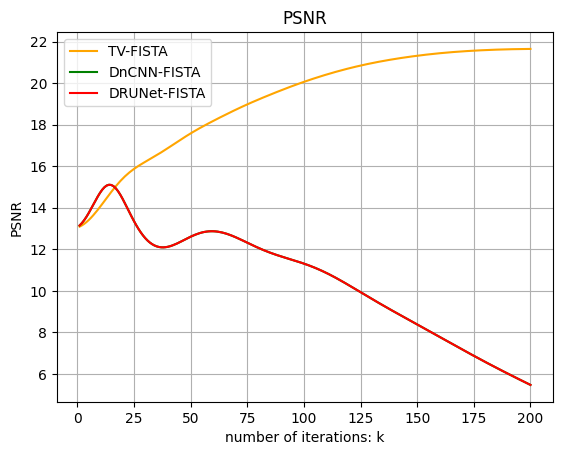

In [157]:
comparison_plot(tvrf,'TV-FISTA', color='orange')
comparison_plot(cnnrf,'DnCNN-FISTA', color='green')
comparison_plot(drurf,'DRUNet-FISTA', color='red')


proximal-PnP PGD iterations: 100%|██████████| 500/500 [00:16<00:00, 29.93it/s]


PnP-proximal Final PSNR: 18.38 dB


tv-PnP PGD iterations: 100%|██████████| 300/300 [00:12<00:00, 24.96it/s]


PnP-tv Final PSNR: 17.35 dB


DnCNN-PnP PGD iterations: 100%|██████████| 50/50 [00:05<00:00,  9.43it/s]


PnP-DnCNN Final PSNR: 15.04 dB


DRUNet-PnP PGD iterations: 100%|██████████| 50/50 [00:05<00:00,  9.60it/s]

PnP-DRUNet Final PSNR: 15.04 dB


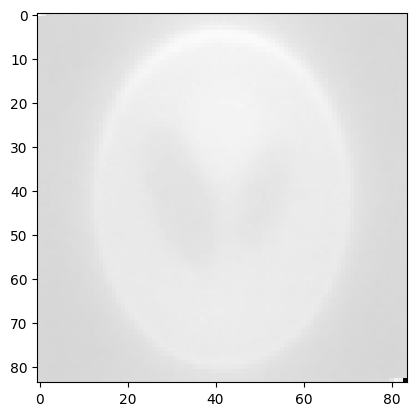

In [86]:
x_prox, proxr, proxdiff, proxpairs = pnp_pgd(A, gauss_y, x, method = 'proximal', iters = 500)
x_tv, tvr, tvdiff, tvpairs = pnp_pgd(A, gauss_y, x, method = 'tv', iters = 300)
x_dncnn, cnnr, cnndiff, cnnpairs = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = 50)
x_drunet, drur, drudiff, drupairs = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = 50)
plt.imshow(x_dncnn.reshape(n,n), cmap='gray')
#CHECK THIS AND THE ALGORITHM ITSELF - MISHAP SOMEWHERE - YOU GOT THIS!


DnCNN-PnP PGD iterations: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


Final PSNR: 15.04 dB


DRUNet-PnP PGD iterations: 100%|██████████| 50/50 [00:05<00:00,  9.49it/s]

Final PSNR: 15.04 dB


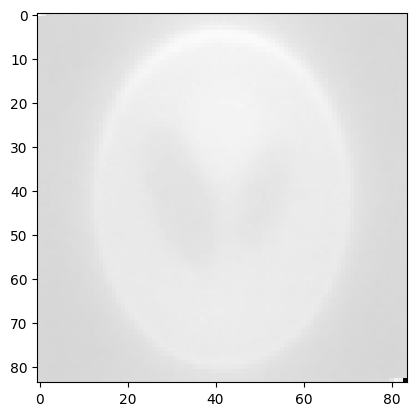

In [47]:
x_dncnn, cnnr, cnndiff, cnnpairs = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = 50)
x_drunet, drur, drudiff, drupairs = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = 50)
plt.imshow(x_dncnn.reshape(n,n), cmap='gray')

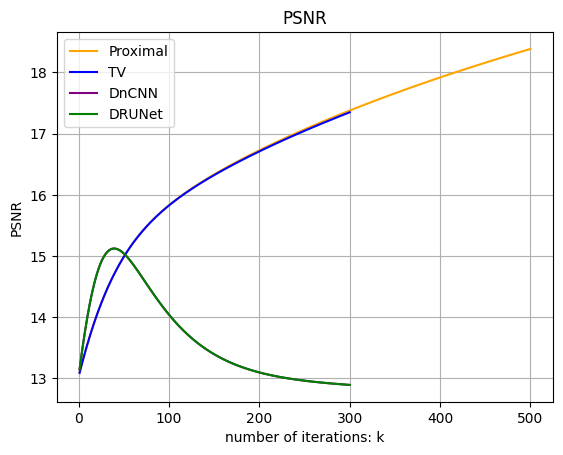

In [46]:
comparison_plot(proxr,'Proximal', color='orange')
comparison_plot(tvr, 'TV', color='blue')
#comparison_plot(bm3r, 'BM3D', color='red')
comparison_plot(cnnr, 'DnCNN', color='purple')
comparison_plot(drur, 'DRUNet', color='green')

In [106]:
x_bm3d, bm3dr, bm3dd, bm3dpairs = pnp_pgd(A, gauss_y, x, 'bm3d', iters = 100)

bm3d-PnP PGD iterations: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]

Final PSNR: 8.05 dB


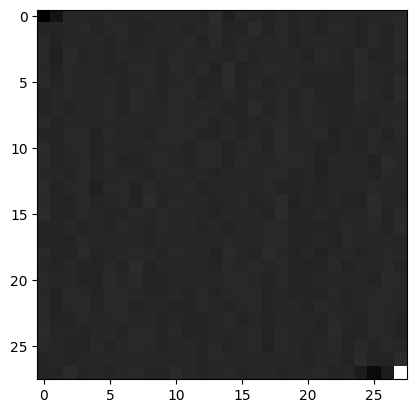

In [107]:
de = cnndiff
len(de)
plt.imshow(de[-2].reshape(imsize), cmap = 'gray')

# Noise distribution between iterates for the denoisers $(D(x^{(k)}) - x^{(k)})$

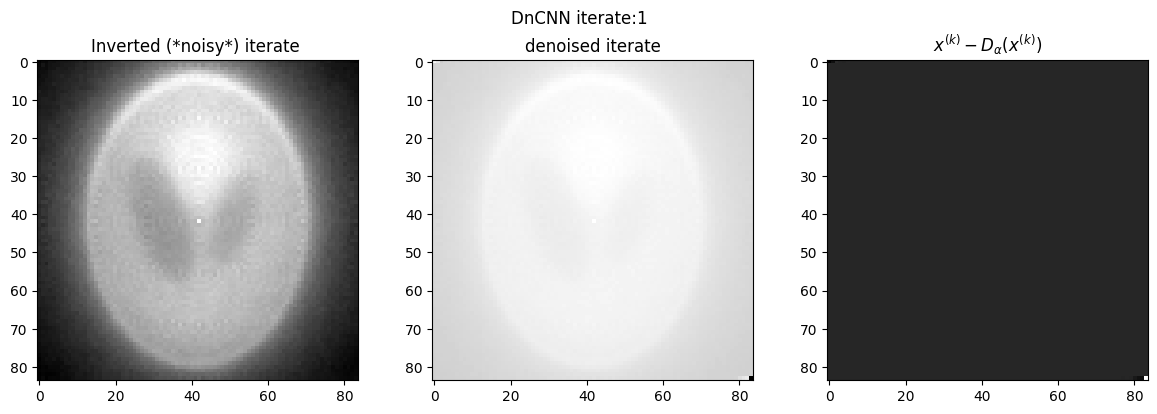

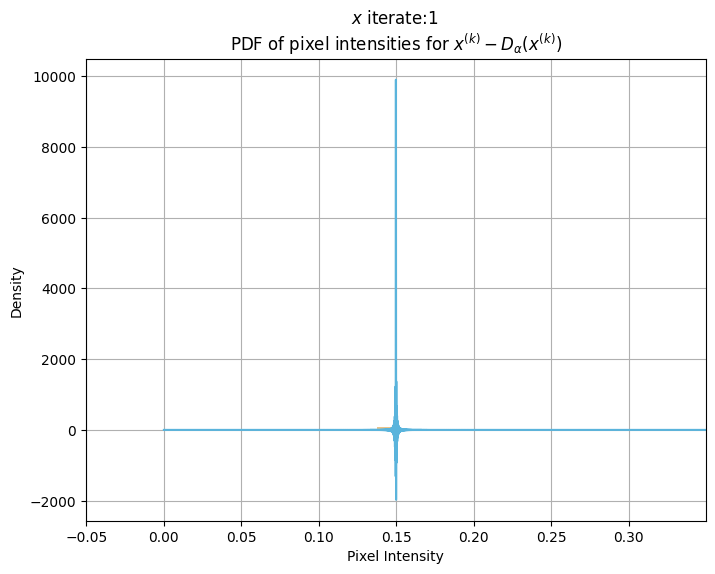

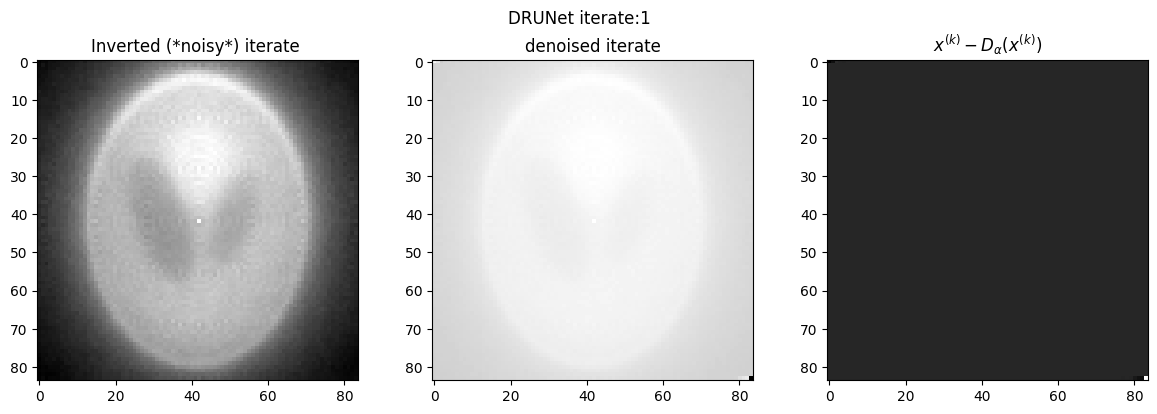

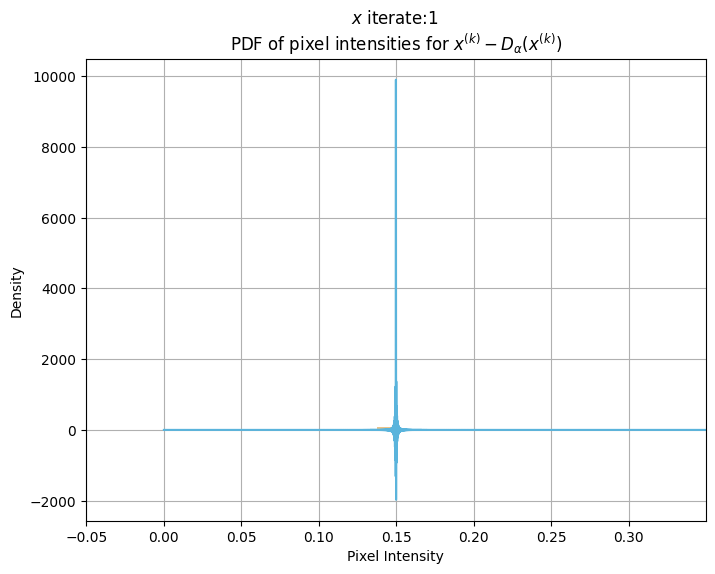

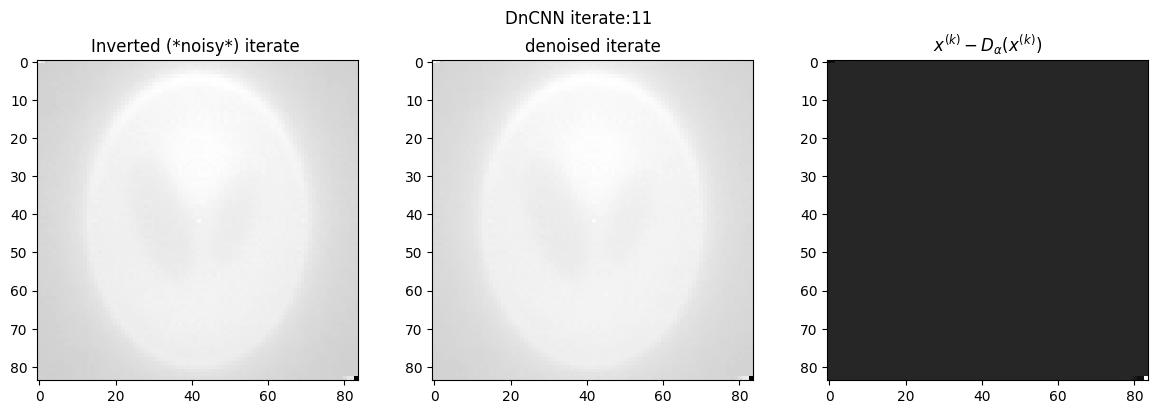

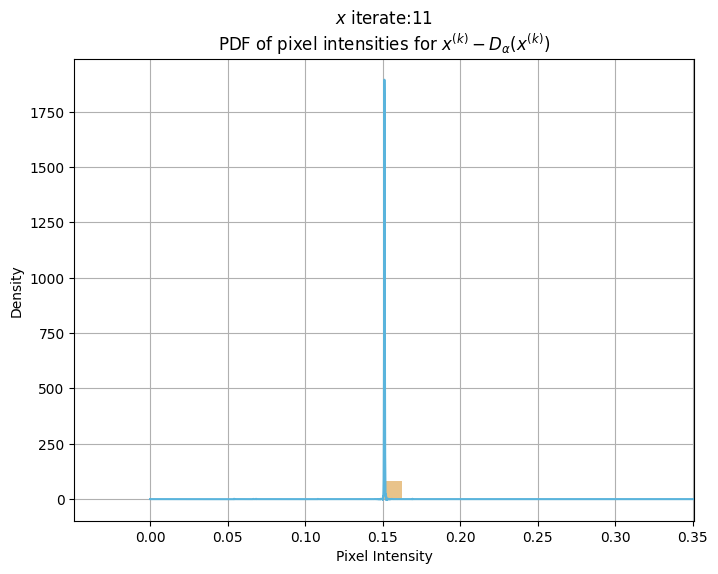

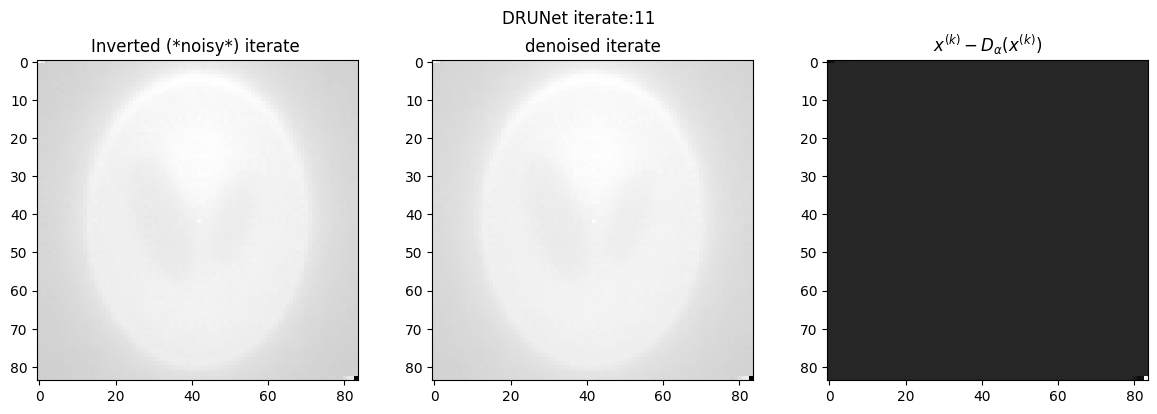

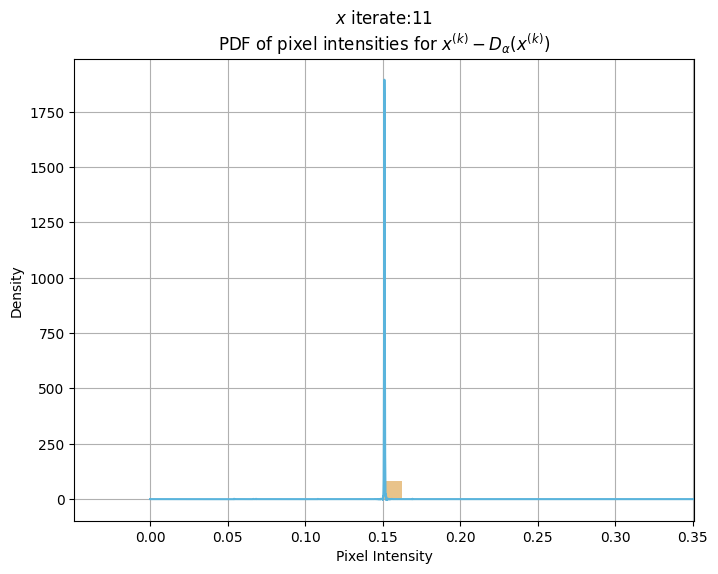

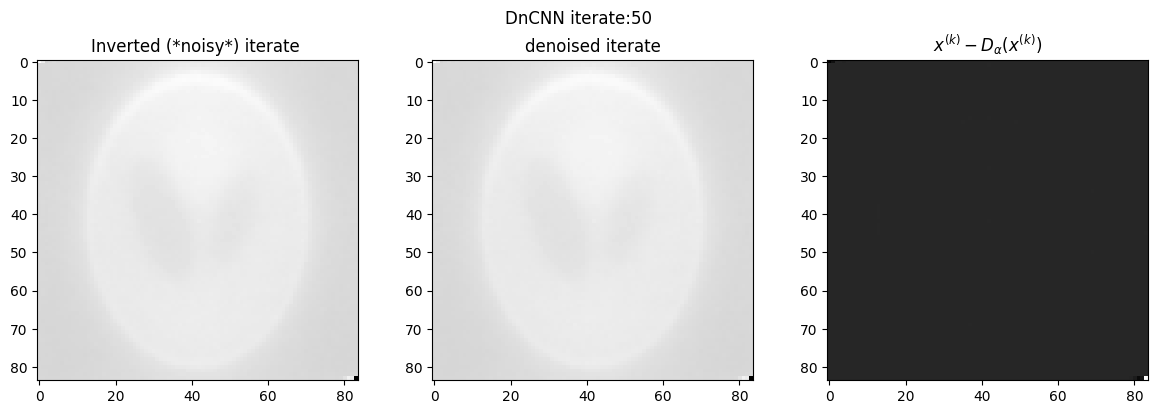

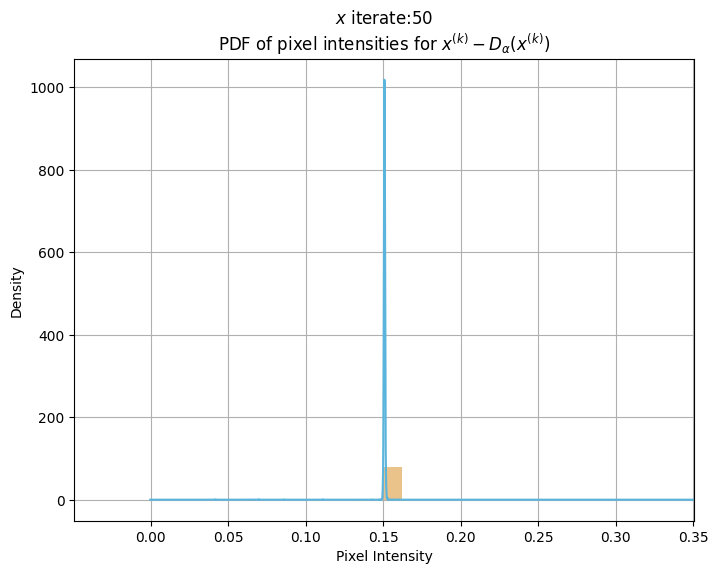

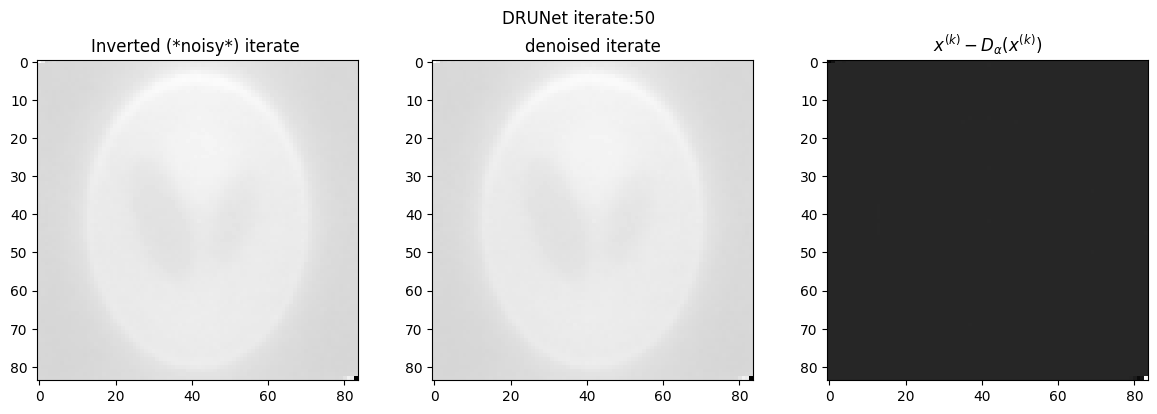

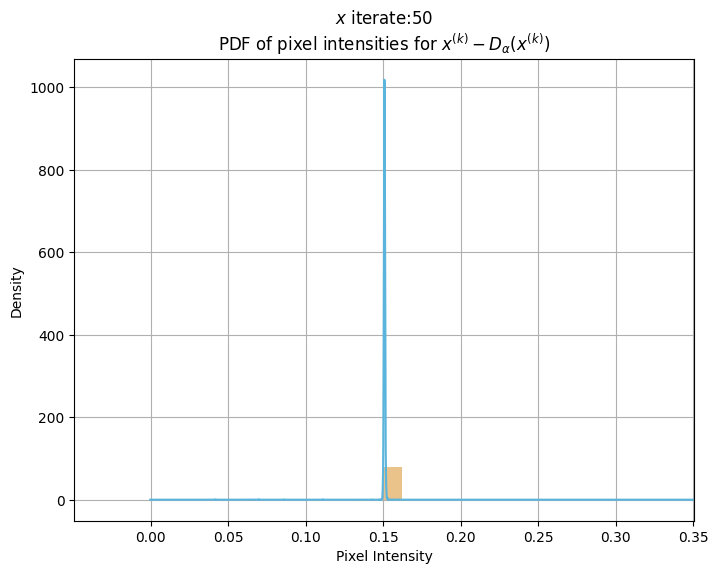

In [48]:
import seaborn as sns
import statsmodels.api as sm
def pdf_plot(noise_diff, iterates_pairs, iteration, title):
    """
    Plotting the differences between inverted and denoised iterates of x^(k)
    """
    fig1, axs = plt.subplots(1, 3, figsize=(12, 4))
    noised_x = iterates_pairs[iteration][0].reshape(imsize)
    denoised_x = iterates_pairs[iteration][1].reshape(imsize)
    fig1.suptitle(title + str(iteration + 1))
    axs[0].imshow(noised_x, cmap = 'gray')
    axs[1].imshow(denoised_x, cmap = 'gray')
    axs[2].imshow(noise_diff.reshape(imsize), cmap = 'gray')

    axs[0].set_title('Inverted (*noisy*) iterate ')
    axs[1].set_title('denoised iterate')
    axs[2].set_title('$x^{(k)} - D_{\\alpha}(x^{(k)})$')
    plt.tight_layout()
    plt.show()

    #Normalising the pixel values
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    iterate = "$x$ iterate:" + str(iteration+1)

    #Compute kernel density estimate (kde for pdf of noise distribution)
    fig2 = plt.figure(figsize=(8,6))
    kde = sm.nonparametric.KDEUnivariate(noise_diff) 
    kde.fit()

    peak_index = np.argmax(kde.density)
    peak_value = kde.support[peak_index]
    # Set the range around the peak
    x_range = kde.support[(kde.support >= peak_value - 2) & (kde.support <= peak_value + 2)]
    
    #fig = plt.figure(layout="constrained", figsize=(12, 5))
    plt.hist(noise_diff, density = True, bins = 80, alpha = 0.5, color="#D58817")
    plt.plot(kde.support, kde.density, color="#5AB4DC")
    #sns.kdeplot(noise_diff.numpy(), fill = True, color='g')

    plt.xlim([peak_value-0.2, peak_value + 0.2])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title(iterate + " \nPDF of pixel intensities for $x^{(k)} - D_{\\alpha}(x^{(k)})$")
    plt.grid(True)
    plt.show()
    
    #plt.hist(noise_diff.numpy(), bins=35, density=True, alpha=0.6, color='g')
    
shift = 0
iterates = [0, 10, 49] 
for i in iterates:
    #pdf_plot(proxdiff[i+shift], proxpairs, iteration = i+shift, title = "Prox iterate:")
    #pdf_plot(tvdiff[i+shift], tvpairs, iteration = i+shift, title = "TV iterate:")
    pdf_plot(cnndiff[i+shift], cnnpairs, iteration = i+shift, title = "DnCNN iterate:")
    pdf_plot(drudiff[i+shift], drupairs, iteration = i+shift, title = "DRUNet iterate:")
    #pdf_plot(bm3dd[i+shift-50], bm3dpairs, iteration = i+shift-50, title = "BM3D iterate:")

In [49]:
def apply_denoiser(x, l, sigma = sigma,  method = 'tv'):
        """
        Denoiser options to replace the proximal step
        """
        L = torch.norm(A) ** 2  # Lipschitz constant
        if method == 'tv':
            return denoise_tv_chambolle_torch(x, weight = l)
        elif method == 'bm3d':
            print()
            #x = torch.to_numpy(x)
            #print(x.shape)
            x = bm3d(x.reshape(imsize), sigma_psd = 2.9).flatten()
            return torch.from_numpy(x).float()
        elif method == 'proximal':
            return soft_thresh(x, l)
        elif method == 'DnCNN':
            #print('DnCNN')
            x = x.unsqueeze(0).unsqueeze(0)
            x = dncnn(x, sigma = sigma)
            return x.squeeze(0).squeeze(0)
        elif method == 'DRUNet':
            #print('DRUNet')
            x = x.unsqueeze(0).unsqueeze(0)
            x = dncnn(x, sigma = sigma)
            return x.squeeze(0).squeeze(0)
        elif method == "GS-DRUNet":
            print('GS')
            x = x.unsqueeze(0).unsqueeze(0)
            x = gsdrunet(x)
            return True

In [50]:
y.shape

torch.Size([119, 60])

In [53]:
#PnP-ADMM (torch version)
def pnp_admm(A, b, x_ground_truth, denoiser, niter = 50, beta = 1e+1, lamb = 1, sigma = sigma):
    n = int(torch.sqrt(torch.tensor(A.shape[1])))
    
    # Define the 3 variables for use
    x = torch.zeros_like(x_ground_truth)
    u = torch.zeros_like(x_ground_truth)
    v = torch.zeros_like(x_ground_truth)
    psnrs = []
    iterates_pairs = []
    diffs = []
    increments =[]
    inv_beta = 1/beta

    # PnP ADMM iteration performed on the 3 variables
    for i in tqdm(range(niter), desc= str(denoiser) + '-PnP ADMM iterations'):
        x_k = x
        #print("b shape:", b.shape)
        #measurement = b.reshape((int(torch.ceil(n * torch.sqrt(torch.tensor(2)))), n))
        correction = (A @ (inv_beta * (u - v)))
        #print("correction shape:", correction.shape)
        #print("b shape:", b.shape)
        sinogram = b + correction.reshape(119, 60)
        #print("b shape:", b.shape)
        x = fbp(sinogram, n_angles).flatten().float()
        #print("x fbp shape:", x.shape)

        # Reshaping u and v for the denoiser (2D shape)
        #u = u.reshape((n, n))
        #v = v.reshape((n, n))
        u = apply_denoiser(x + v, lamb, method = denoiser).float()
        #print("u shape:", u.shape)
        

        v = (v + x - u).float()

        # Flattening u and v for the next iteration (2D to 1D)
        #u = u.flatten()
        #v = v.flatten()


        increment = torch.norm(x - x_k)
        diff = x - u

        #inverted and denoised iterates stored
        iterates_pairs.append((x, u))
        
        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)
        
        increments.append(increment)
        #difference between "noisy and denoised iterates"
        diffs.append(diff)

        current_psnr = PSNR(x_ground_truth, x)
        psnrs.append(current_psnr)

    print(f"Final PSNR: {current_psnr:.2f} dB")

    return x, psnrs, diffs, iterates_pairs, increments
    



In [ ]:
i = 20
admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = i, beta = 10, lamb = 1)
admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs, abm3dincr = pnp_admm(A, gauss_y, x, 'bm3d', niter = i)

In [58]:
iters = 200
admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = iters, beta = 10, lamb = 1)

admm_tv, atvpsnr, atvdiff, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = iters, lamb= 1, beta = 10)
admm_dncnn, adncnnpsnr, acnndiff, adncnnpairs, adncnnincr  = pnp_admm(A, gauss_y, x, 'DnCNN', niter = iters)
admm_dru, adrunetpsnr, adrudiff, adrupairs, adruincr = pnp_admm(A, gauss_y, x, 'DRUNet', niter = iters)



proximal-PnP ADMM iterations: 100%|██████████| 200/200 [00:09<00:00, 21.74it/s]


Final PSNR: 21.20 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:12<00:00, 15.82it/s]


Final PSNR: 22.86 dB


DnCNN-PnP ADMM iterations: 100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


Final PSNR: 20.10 dB


DRUNet-PnP ADMM iterations: 100%|██████████| 200/200 [00:22<00:00,  9.07it/s]

Final PSNR: 20.10 dB


In [ ]:
admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs, abm3dincr = pnp_admm(A, gauss_y, x, 'bm3d', niter = iters)

In [128]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
betas = [1e+2, 1e+1]
best = 0
b_lamb, b_beta = 0, 0
for lamb in lambdas:
    for beta in betas:
        tv, tvp, tvd, tvpairs = pnp_admm(A, gauss_y, x, 'tv', niter = iters, beta = beta, lamb= lamb)
        if tvp[-1] > best:
            best = tvp[-1]
            b_lamb, b_beta = lamb, beta

print("Best beta:", b_beta, "\n Best lambda:", b_lamb)
beta = 1e+1
lamb = 1


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:00<00:00, 246.66it/s]


Final PSNR: 19.80 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:00<00:00, 247.23it/s]


Final PSNR: 19.51 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:00<00:00, 240.13it/s]


Final PSNR: 19.80 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:00<00:00, 223.30it/s]


Final PSNR: 19.51 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:01<00:00, 193.99it/s]


Final PSNR: 19.80 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:01<00:00, 165.08it/s]


Final PSNR: 19.54 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:02<00:00, 78.94it/s]


Final PSNR: 19.83 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:02<00:00, 80.47it/s]


Final PSNR: 19.79 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:04<00:00, 48.87it/s]


Final PSNR: 20.03 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:04<00:00, 49.85it/s]


Final PSNR: 21.00 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:04<00:00, 43.28it/s]


Final PSNR: 20.41 dB


tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:06<00:00, 29.11it/s]

Final PSNR: 15.80 dB
Best beta: 10.0 
 Best lambda: 1


<>:15: SyntaxWarning: invalid escape sequence '\|'
<>:15: SyntaxWarning: invalid escape sequence '\|'
C:\Users\as5057\AppData\Local\Temp\ipykernel_18400\853080505.py:15: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|$')


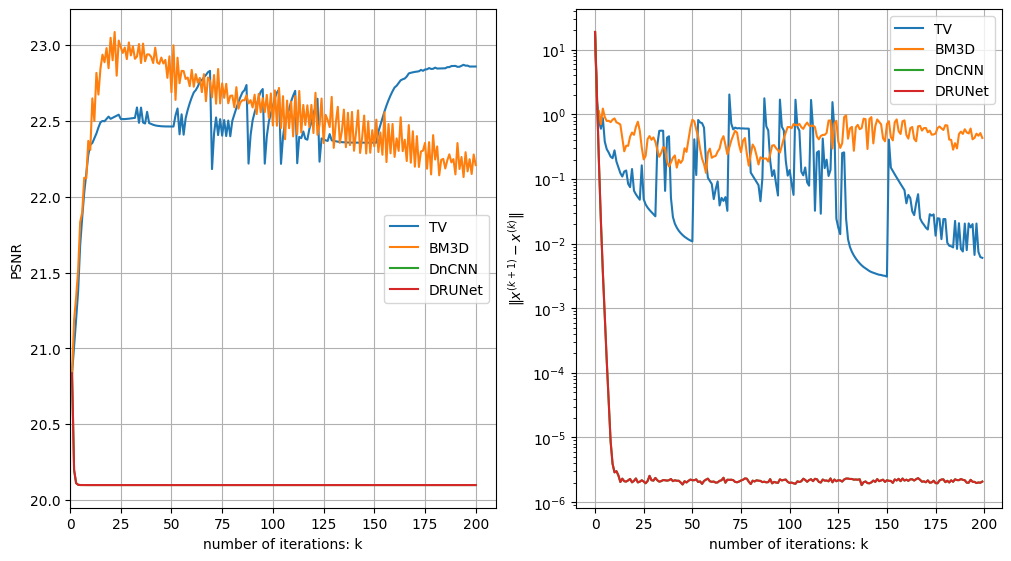

In [75]:
#Main plotting and reconstruction functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)
    ax1.set_xlim([0, len(psnrs)+10])
    ax2.semilogy(diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    
    return psnrs[-1]

#proxpsnr = plot_psnrs_differences(aproxpsnr, aproxincr, 'Prox')
tvpsnr = plot_psnrs_differences(atvpsnr, atvincr, 'TV')
bm3dpsnr = plot_psnrs_differences(abm3dpsnr, abm3dincr, 'BM3D')
dncnnpsnr = plot_psnrs_differences(adncnnpsnr, adncnnincr, 'DnCNN')
drunetpsnr = plot_psnrs_differences(adrunetpsnr, adruincr, 'DRUNet')

psnrs_list = [tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr]

ax1.legend()
ax2.legend()

In [69]:
def plotting_estimates(gt, fbp, x1, x2, x3, x4, psnrs_list, title):
    size = 15
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(title, size = 20)
    axs[0, 0].set_title("Ground Truth", fontsize = size)
    axs[0, 0].imshow(gt, cmap='gray')
    axs[0, 1].set_title("FBP", fontsize = size)
    axs[0, 1].imshow(fbp, cmap='gray')
    axs[0, 2].set_title(f'TV \n PSNR: {psnrs_list[0]:.2f} dB', fontsize = size)
    axs[0, 2].imshow(x1, cmap='gray')
    axs[1, 0].set_title(f'BM3D \n PSNR: {psnrs_list[1]:.2f} dB', fontsize = size)
    axs[1, 0].imshow(x2, cmap='gray')
    axs[1, 1].set_title(f'PnP-DnCNN \n PSNR: {psnrs_list[2]:.2f} dB', fontsize = size)
    axs[1, 1].imshow(x3, cmap='gray')
    axs[1, 2].set_title(f'PnP-DRUNet \n PSNR: {psnrs_list[3]:.2f} dB', fontsize = size)
    axs[1, 2].imshow(x4, cmap='gray')

    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')

imsize = (n, n)

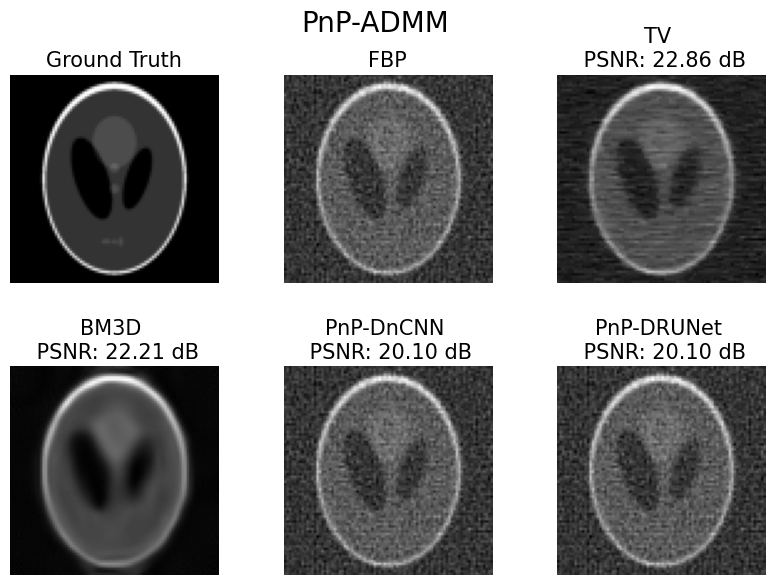

In [70]:
plotting_estimates(x.reshape(imsize), gfbp.reshape(imsize), admm_tv.reshape(imsize), admm_bm3d.reshape(imsize), admm_dncnn.reshape(imsize), admm_dru.reshape(imsize), psnrs_list, 'PnP-ADMM')

C:\Users\as5057\AppData\Local\Temp\ipykernel_1548\314283590.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


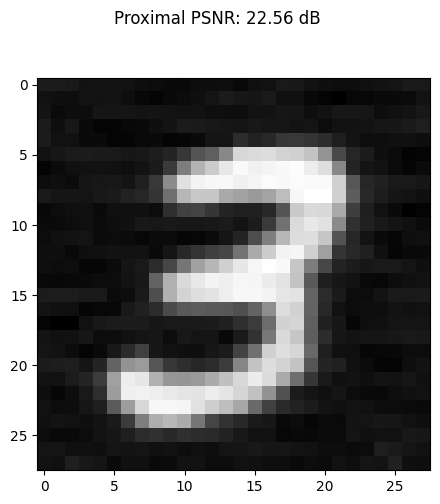

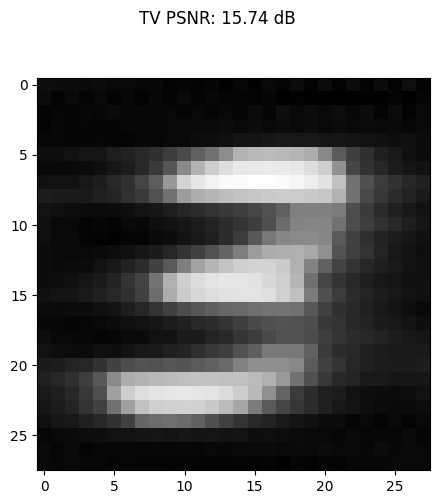

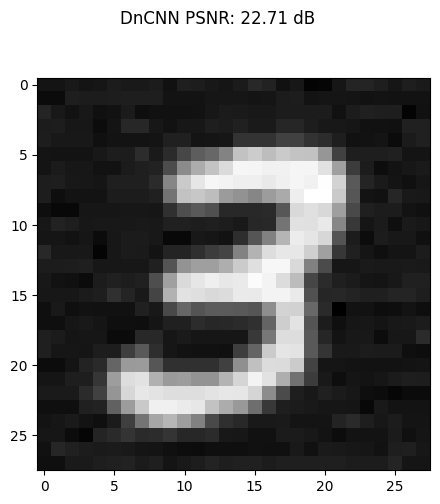

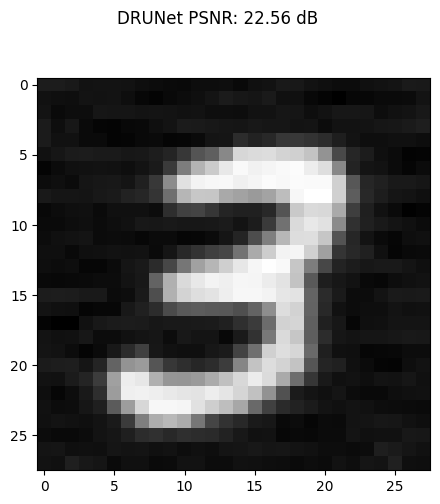

In [ ]:
display_images([x_prox.reshape(imsize), tv.reshape(imsize), x_d.reshape(imsize), x_dru.reshape(imsize)], ['Proximal','TV', 'DnCNN', 'DRUNet'], x)

# Residual noise distribution
## Figures
- Before - $x^{(k)}$ image
- After - $D(x^{(k)})$ image
- $D(x) - x$ image
- Histogram (pdf) of the individual pixels of $(D(x^{(k)}_i) - x^{(k)}_i)$ (784 items)



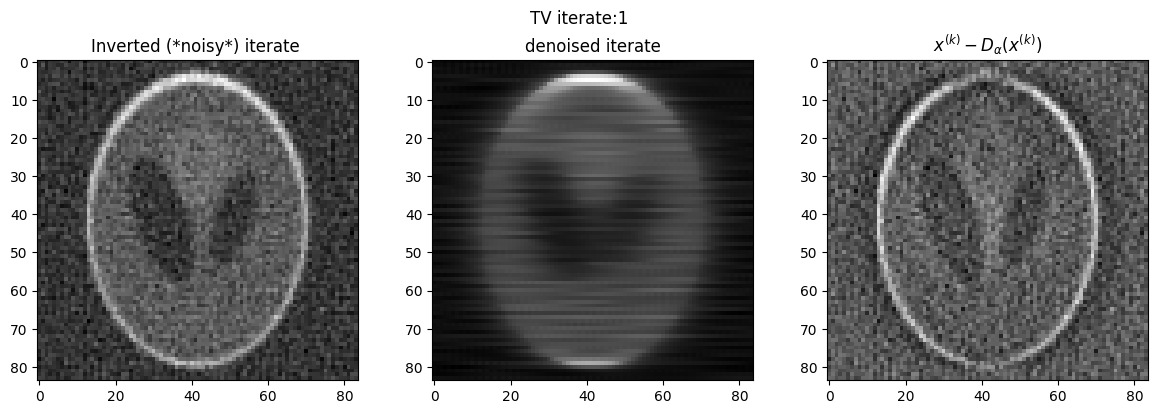

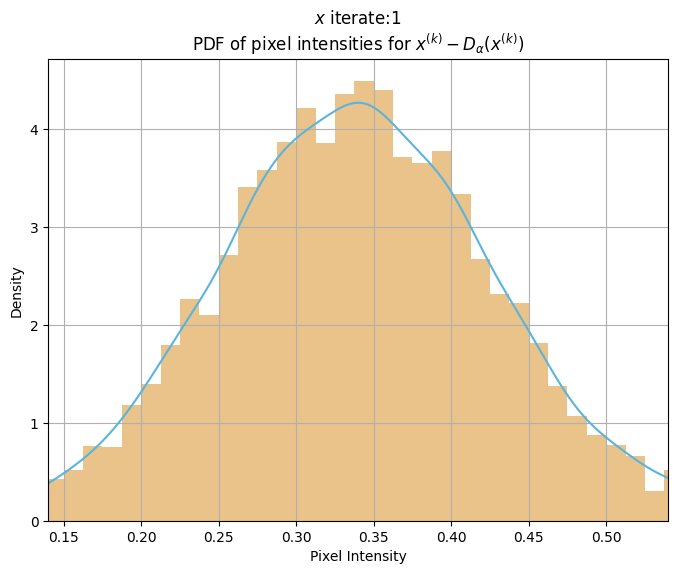

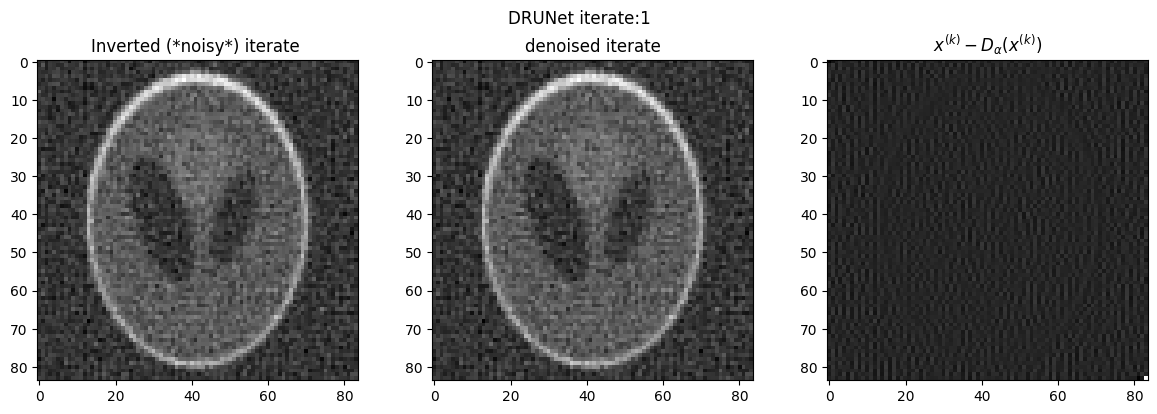

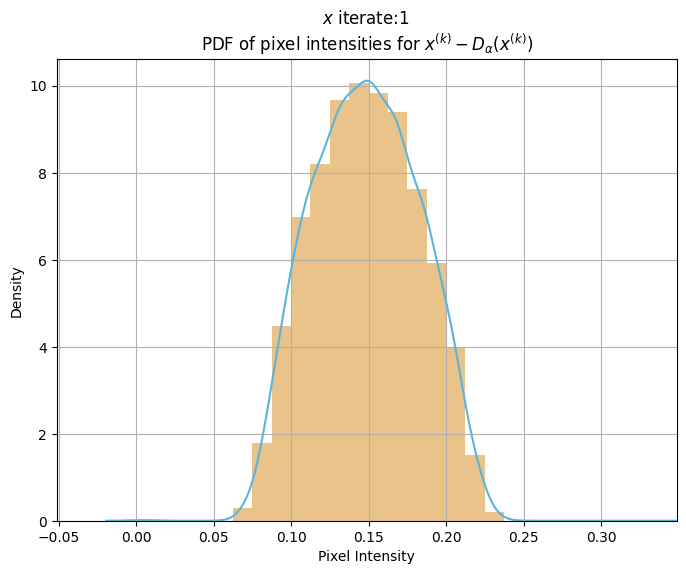

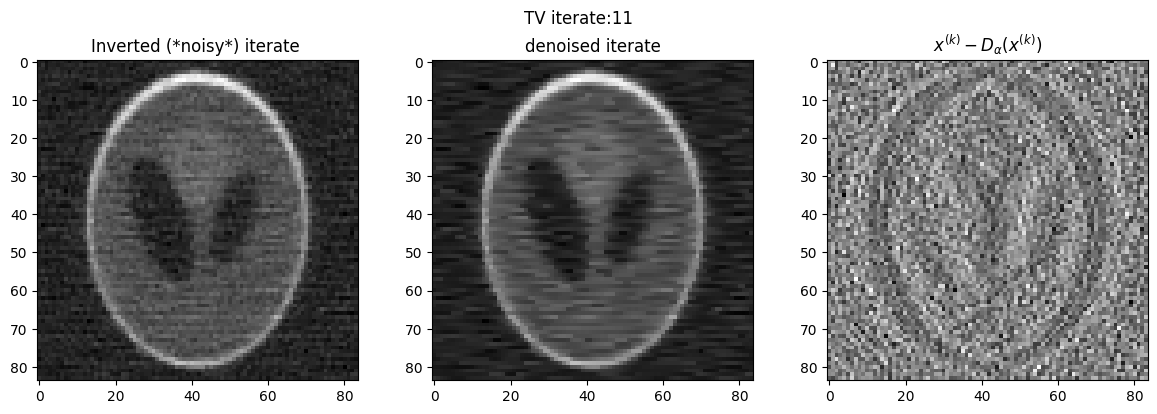

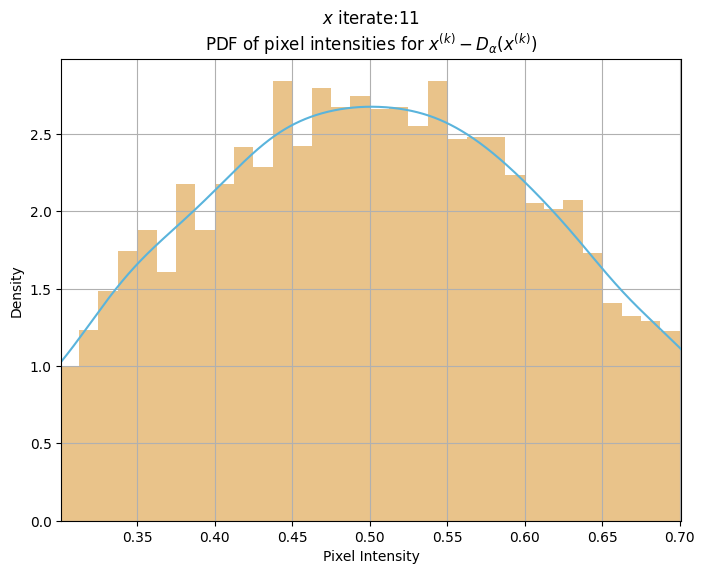

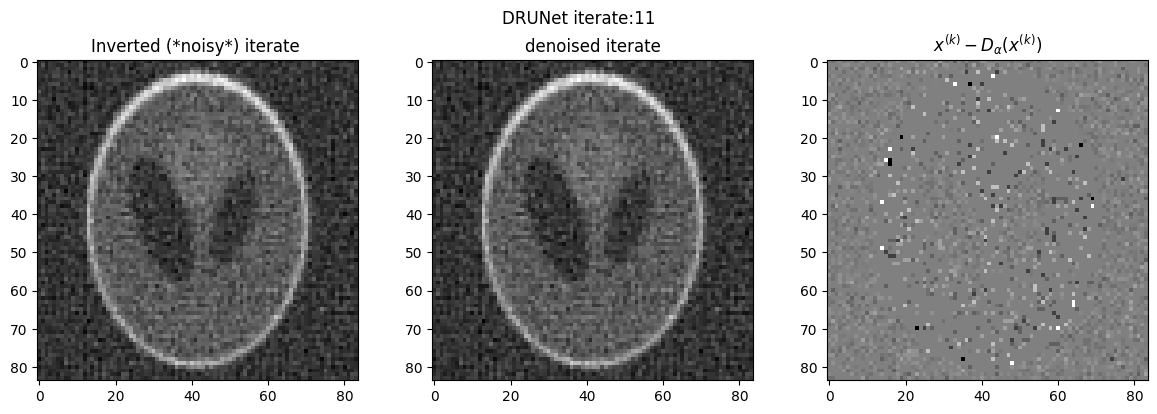

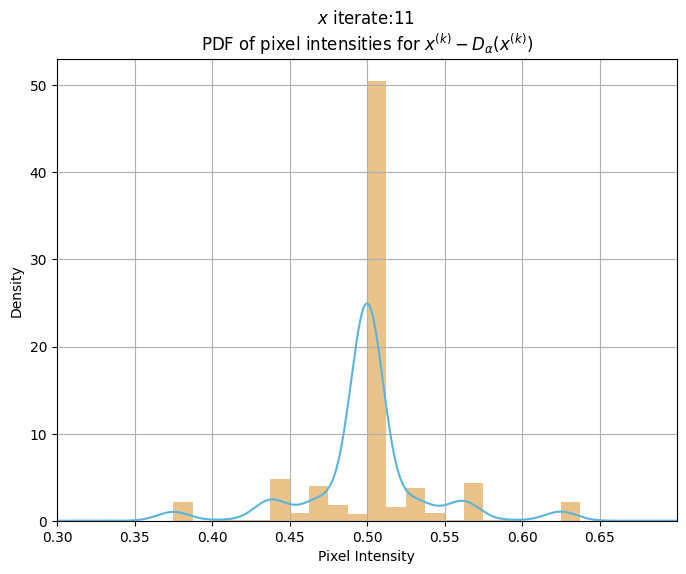

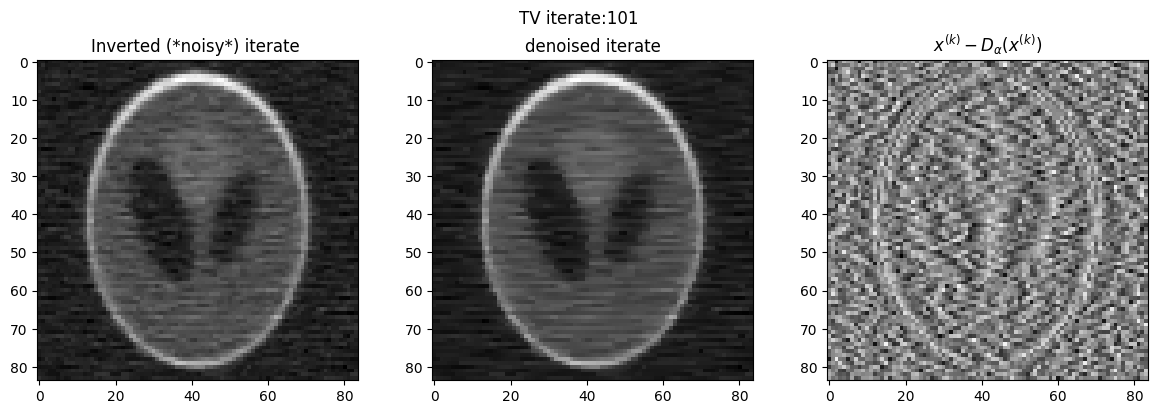

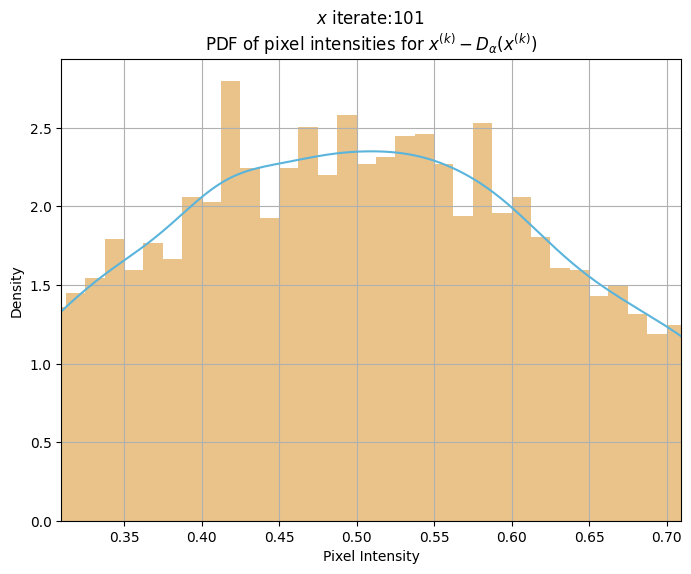

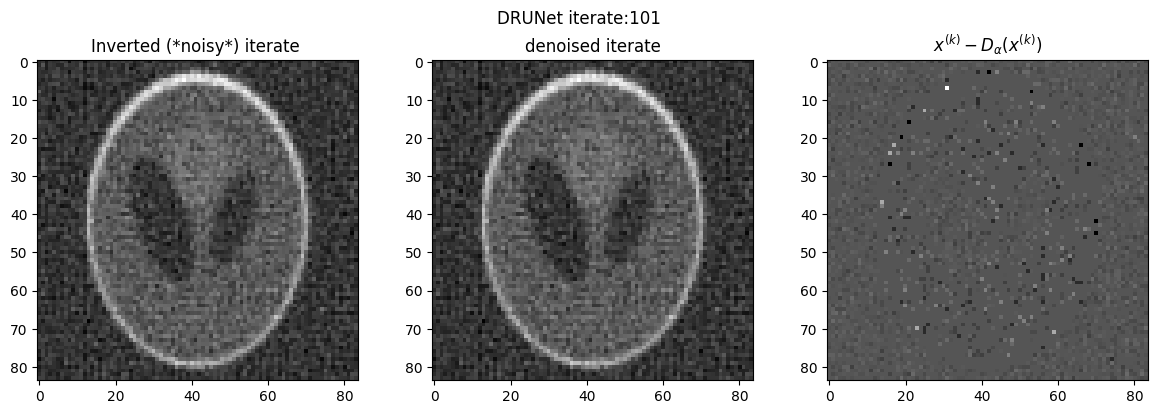

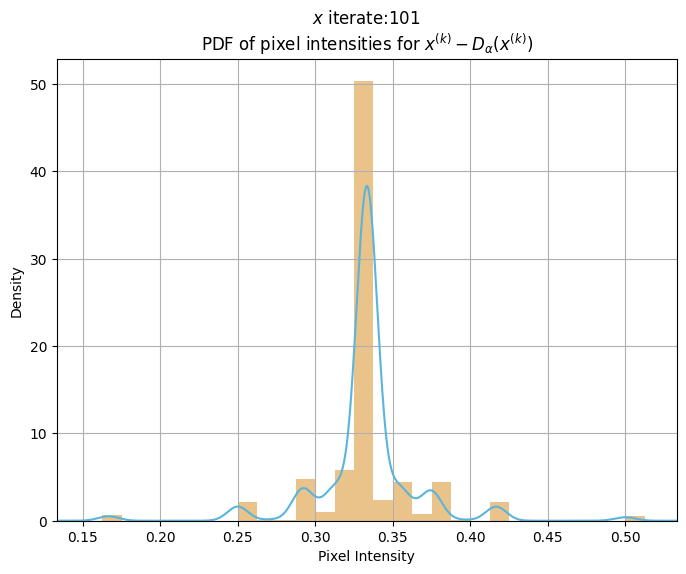

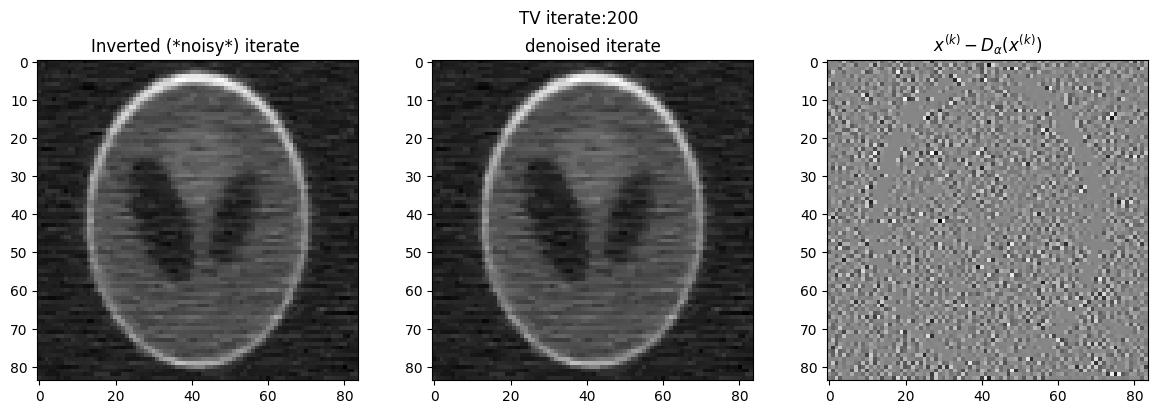

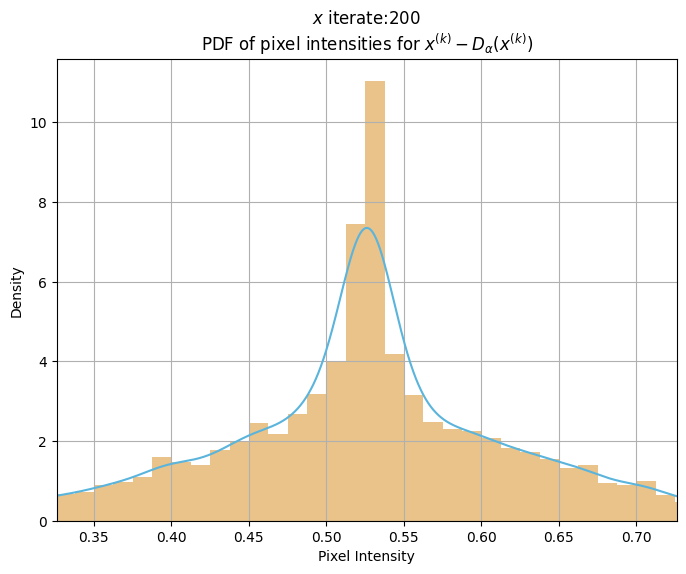

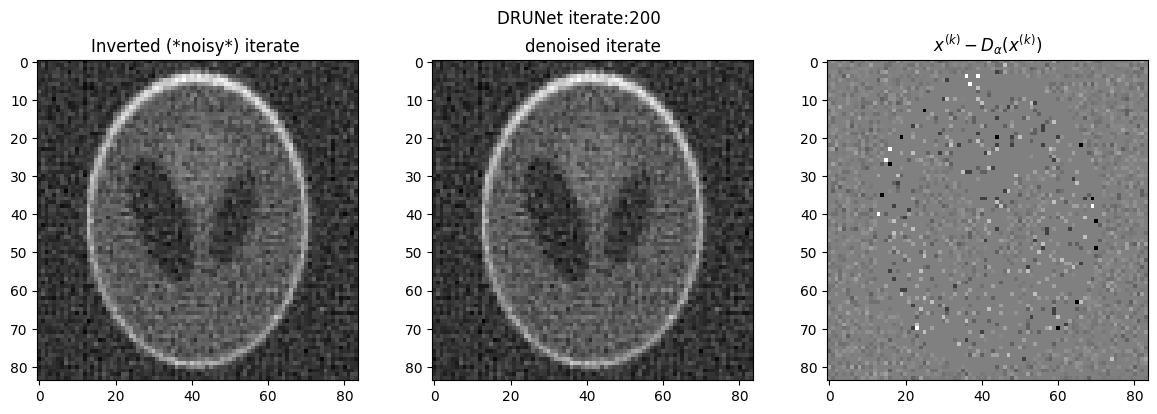

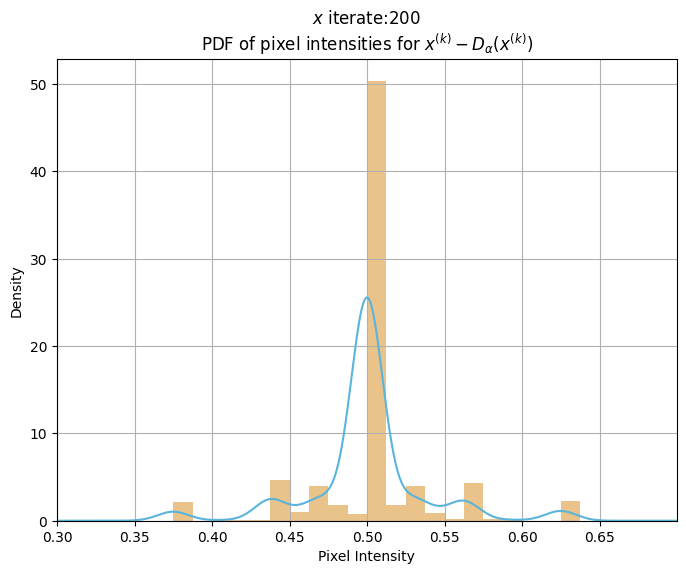

In [72]:
shift = 0
iterates = [0, 10, 100, 199]
for i in iterates:
    #pdf_plot(aproxdiff[i+shift], aproxpairs, iteration = i+shift, title = "Prox iterate:")
    pdf_plot(atvdiff[i+shift], atvpairs, iteration = i+shift, title = "TV iterate:")
    #pdf_plot(acnndiff[i+shift], adncnnpairs, iteration = i+shift, title = "DnCNN iterate:")
    pdf_plot(adrudiff[i+shift], adrupairs, iteration = i+shift, title = "DRUNet iterate:")
    #pdf_plot(bm3dd[i+shift-50], bm3dpairs, iteration = i+shift-50, title = "BM3D iterate:")